In [1]:
##################################################################################################################
#Import section
from scipy import io
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from math import isnan
import numpy.ma as ma

import plotly.plotly as py
import plotly.graph_objs as go

##################################################################################################################
#Loading the file
from loader import load
file_name = 'V1_SESSION_B20141210_1.mat'
mat = io.loadmat(file_name)["DATA_SESSION"]

In [2]:
##################################################################################################################
#Tool box

def compute_mask(data):
    plop = data["LUM"][0][0]["psMS_S"][0][0]
    a = np.nanmean(plop,axis=2)
    b = np.nanmean(a,axis=0)
    c = list(map(lambda x : not isnan(x),b))
    return c

def nan_mask(data,index):
    mask = np.nanmean(data,axis=index)
    mask = list(map(lambda x : not isnan(x),mask))
    return mask

def remove_nan(data,index):
    mask = nan_mask(data,index)
    if index==0:
        return data[:,mask]
    else:
        return data[mask,:]


def compute_too_much_mask(data,threshold=0.9):
    global_mean = np.nanmean(data)
    a = np.mean(data,axis=0)
    c = list(map(lambda x : x < threshold*global_mean,a))
    return c


def smoother(data,window=10):
    result = []
    for i in range(len(data)):
        a = data[int(max(0,i-window/2)):int(min(len(data-1),i+window/2))]
        result.append(np.mean(a))
    return result

def get_data(full_data,data_type,average_over_trials=True):
    if average_over_trials:
        text="AverageTrials"
    else:
        text="AllTrials"
    if data_type == "correct_rejections":
        data = full_data["Conditions"][0][0][text][0][0]["CR"][0][0]
    elif data_type == "false_alarm":
        pass
    elif data_type == "seen":
        data = full_data["Conditions"][0][0][text][0][0]["LUM"][0][0]["Seen"][0]
    elif data_type == "missed":
        data = full_data["Conditions"][0][0][text][0][0]["LUM"][0][0]["Missed"][0]
    elif data_type == "time":
        data = full_data["SessionInfo"][0][0]["Time"][0][0][0]
    else:
        raise(BaseException("Data Type not found"))
    return data

def average_over(data,time=False,channels=False,trials=False,contrast=False):
    if contrast:
        averaged_data = []
        for trial_data in data:
            trial_data_averaged = average_over(trial_data,time=time,channels=channels,trials=trials)
            averaged_data.append(trial_data_averaged)

        data = np.asarray(averaged_data)
        data = np.nanmean(averaged_data,0)
    else:
        if trials:
            data = np.nanmean(data,2)
        if channels:
            data = np.nanmean(data,1)
        if time:
            data = np.nanmean(data,0)
    return data

def array_smoother(data,window=50):
    smoothed_data = []
    for i in range(len(data[0])):
        smoothed_data.append(smoother(data[:,i]-np.nanmean(data[:,i],axis=0),window))
    return smoothed_data

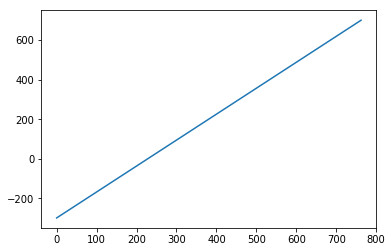

In [3]:
###################################################################################################################
#Getting the timing step
timing_step = get_data(mat,"time")*1000

plt.plot(timing_step)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

Mean of empty slice



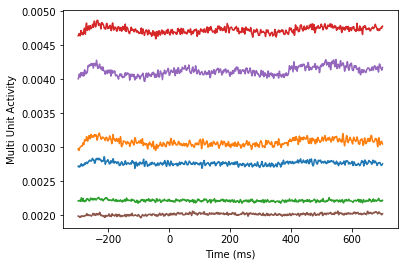

In [28]:
##################################################################################################################
#Ploting average over trials for each electrodes for correct rejections trials

#Gathering Correct rejection data
correct_rejection_data = get_data(mat,"correct_rejections",average_over_trials=False)
#Averaging over trials
correct_rejection_data_averaged = average_over(correct_rejection_data,time=False,channels=False,trials=True)
#Cleaning corrupted channels
correct_rejection_data_cleaned = remove_nan(correct_rejection_data_averaged,0)


#Ploting the graph
for i in range(len(correct_rejection_data_cleaned[1,:])):
    plt.plot(timing_step,correct_rejection_data_cleaned[:,i])
plt.xlabel("Time (ms)")
plt.ylabel("Multi Unit Activity")
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning:

Mean of empty slice



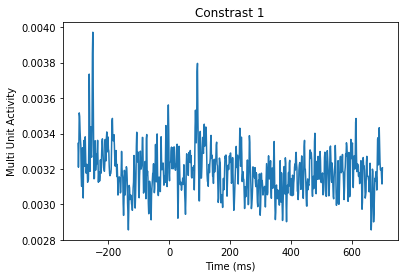

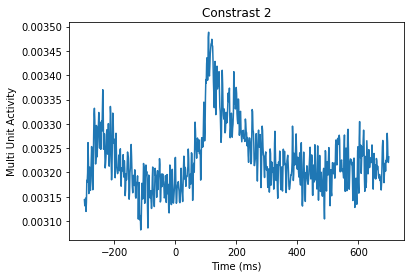

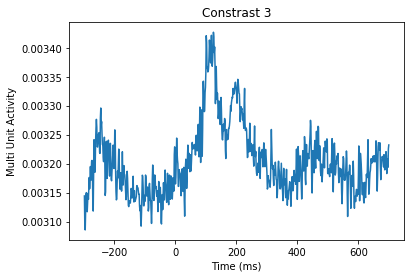

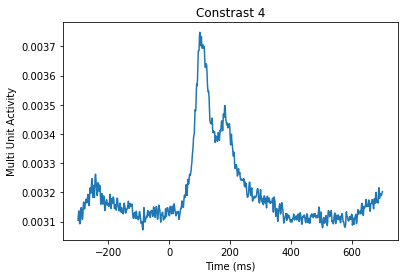

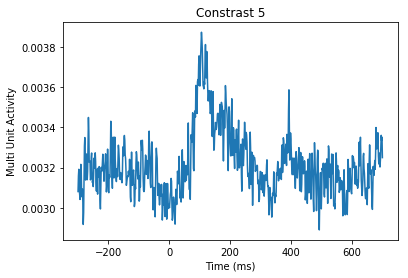

<Figure size 432x288 with 0 Axes>

In [30]:
##################################################################################################################
#Ploting average over trials over electrodes for each contrast category for Seen trials

#Gathering Seen trials data
seen_averaged_data = get_data(mat,'seen',average_over_trials=False)


#Ploting the graphs
for i in range(len(seen_averaged_data)):
    #Average over electrodes
    seen_averaged_data_cleaned = average_over(seen_averaged_data[i],time=False,channels=True,trials=True)
    #Finally ploting
    plt.plot(timing_step,seen_averaged_data_cleaned)
    plt.title("Constrast " + str(i+1))
    plt.xlabel("Time (ms)")
    plt.ylabel("Multi Unit Activity")
    plt.figure()
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning:

Mean of empty slice



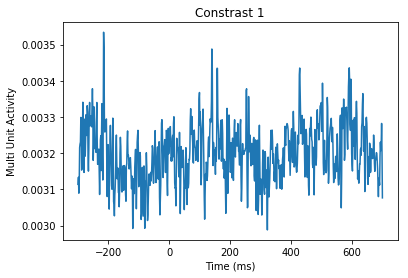

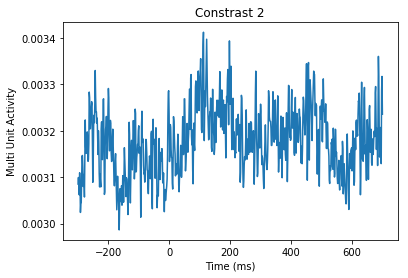

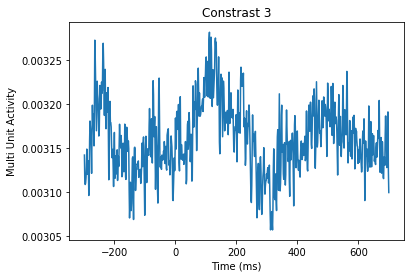

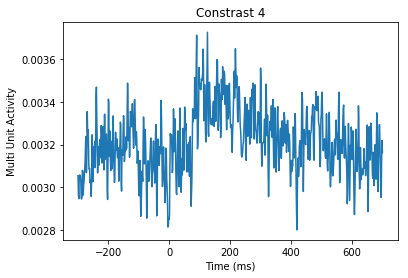

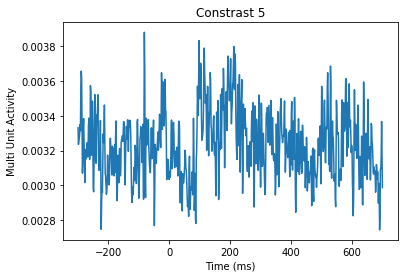

<Figure size 432x288 with 0 Axes>

In [31]:
##################################################################################################################
#Ploting average over trials over electrodes for each contrast category for Missed trials

#Gathering Seen trials data
missed_averaged_data = get_data(mat,'missed',average_over_trials=False)


#Ploting the graphs
for i in range(len(missed_averaged_data)):
    #Average over electrodes
    missed_averaged_data_cleaned = average_over(missed_averaged_data[i],time=False,channels=True,trials=True)
    #Finally ploting
    plt.plot(timing_step,missed_averaged_data_cleaned)
    plt.title("Constrast " + str(i+1))
    plt.xlabel("Time (ms)")
    plt.ylabel("Multi Unit Activity")
    plt.figure()
plt.show()

In [11]:
##################################################################################################################
#Ploting average over electrodes for each seen trial for Constrast in category 4


#Gathering Seen trials data
seen_data = get_data(mat,'seen',average_over_trials=False)[3]
#Averaging over electrodes
seen_data_averaged = average_over(seen_data,time=False,channels=True,trials=False)
#Smoothing the data
final_data = array_smoother(seen_data_averaged,window=10)


#Preparing the graph
data = [
    go.Heatmap(z=final_data,
                   x=np.asarray(range(len(final_data))),
                   y=np.asarray(range(len(final_data[0]))),
                  )
]
#Still preparing the graph
layout = go.Layout(
    title='3D Graph',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)

fig = go.Figure(data=data, layout=layout)

#Ploting the graph
py.iplot(data, filename='basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ulyssek/0 or inside your plot.ly account where it is named 'basic-line'


In [7]:
##################################################################################################################
#Ploting average over electrodes for each seen trial for Constrast in category 4

#Gathering Seen trials data
seen_data = get_data(mat,'seen',average_over_trials=False)[3]
#Averaging over electrodes
seen_data_averaged = average_over(seen_data,time=False,channels=True,trials=False)
#Smoothing the data
final_data = array_smoother(seen_data_averaged,window=50)

#Preparing the graph
data = [
    go.Surface(
        z=final_data
    )
]

#Still preparing the graph
layout = go.Layout(
    title='3D Graph',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)

#Ploting the graph
py.iplot(fig, filename='elevations-3d-surface')